<a href="https://colab.research.google.com/github/binit-13/Machine-Learning-Notes/blob/main/Auto_encoder_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import tensorflow
from tensorflow import keras
from keras.layers import Dense, Input, BatchNormalization, LeakyReLU
from keras.models import Model, load_model
from keras.utils import plot_model


In [4]:
X, y = make_classification(n_samples=1000, n_features=100,n_redundant=30,n_informative=10,random_state=1)

In [5]:
y.shape

(1000,)

In [35]:
n_inputs = X.shape[1]
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:100],df.iloc[:,-1], test_size=0.33, random_state=1)

In [36]:
trns = MinMaxScaler()
trns_X_train = trns.fit_transform(X_train)
trns_X_test = trns.transform(X_test)

In [51]:
## Building a model for autoencoders ---> Total 5 layer --- 2 encode layer/ 1 bottleneck layer / 2 decode layer
visible = Input(shape=(n_inputs,))
##1st layer
en = Dense(n_inputs*2)(visible)
en = BatchNormalization()(en)
en = LeakyReLU()(en)
##2nd Layer
en = Dense(n_inputs*2)(en)
en = BatchNormalization()(en)
en = LeakyReLU()(en)

##Bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(en)

# define decoder, level 1
de = Dense(n_inputs)(bottleneck)
de = BatchNormalization()(de)
de = LeakyReLU()(de)
# decoder level 2
de = Dense(n_inputs*2)(de)
de = BatchNormalization()(de)
de = LeakyReLU()(de)


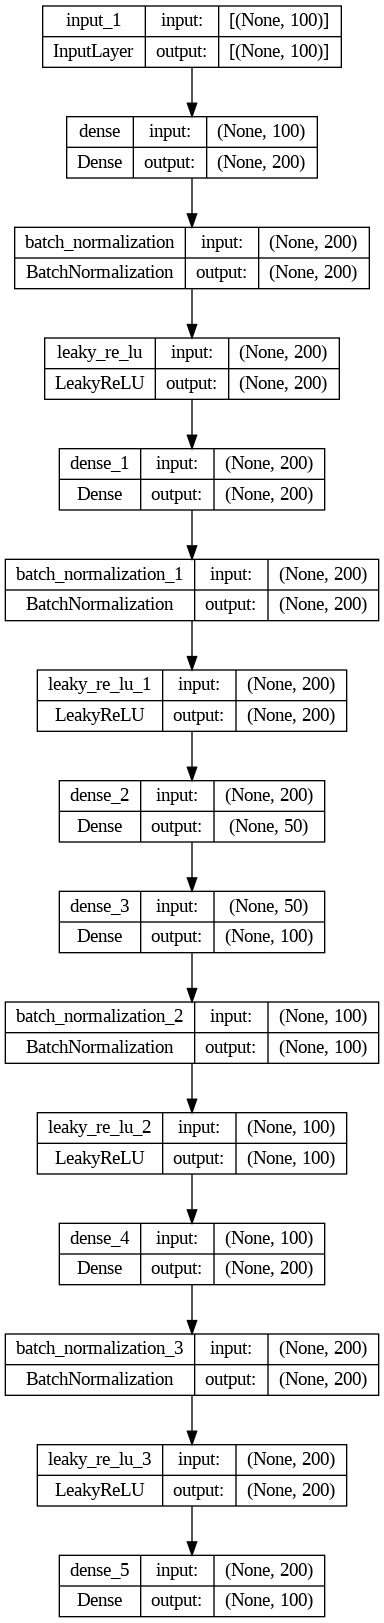

In [52]:
# output layer
output = Dense(n_inputs, activation='linear')(de)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)

Epoch 1/200
42/42 - 3s - loss: 0.2962 - val_loss: 0.1928 - 3s/epoch - 74ms/step
Epoch 2/200
42/42 - 0s - loss: 0.0715 - val_loss: 0.1342 - 215ms/epoch - 5ms/step
Epoch 3/200
42/42 - 0s - loss: 0.0431 - val_loss: 0.0811 - 257ms/epoch - 6ms/step
Epoch 4/200
42/42 - 0s - loss: 0.0344 - val_loss: 0.0470 - 305ms/epoch - 7ms/step
Epoch 5/200
42/42 - 0s - loss: 0.0293 - val_loss: 0.0337 - 298ms/epoch - 7ms/step
Epoch 6/200
42/42 - 0s - loss: 0.0268 - val_loss: 0.0256 - 296ms/epoch - 7ms/step
Epoch 7/200
42/42 - 0s - loss: 0.0252 - val_loss: 0.0229 - 286ms/epoch - 7ms/step
Epoch 8/200
42/42 - 0s - loss: 0.0235 - val_loss: 0.0211 - 284ms/epoch - 7ms/step
Epoch 9/200
42/42 - 0s - loss: 0.0234 - val_loss: 0.0208 - 290ms/epoch - 7ms/step
Epoch 10/200
42/42 - 0s - loss: 0.0220 - val_loss: 0.0195 - 275ms/epoch - 7ms/step
Epoch 11/200
42/42 - 0s - loss: 0.0215 - val_loss: 0.0191 - 287ms/epoch - 7ms/step
Epoch 12/200
42/42 - 0s - loss: 0.0217 - val_loss: 0.0185 - 218ms/epoch - 5ms/step
Epoch 13/200
42

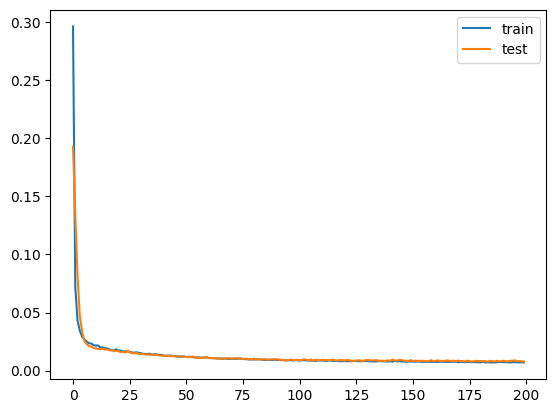

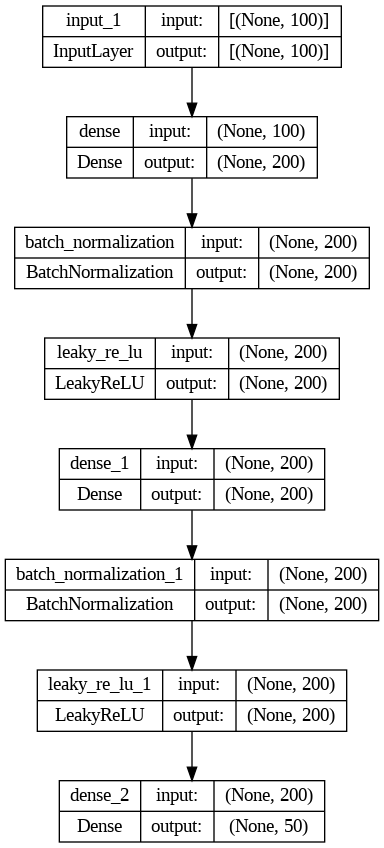

In [53]:
history = model.fit(trns_X_train, trns_X_train, epochs=200, batch_size=16, verbose=2, validation_data=(trns_X_test,trns_X_test))
# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_compress.png', show_shapes=True)

In [54]:
encoder.save('encoder.h5')

In [55]:
encoder = load_model('encoder.h5')

In [57]:
## Vanilla Logistic regression to check the score and see the feature extraction by autoencoder

clf = LogisticRegression()
clf.fit(trns_X_train, y_train)
y_pred = clf.predict(trns_X_test)
print(accuracy_score(y_test, y_pred))

0.9


In [56]:
## Now using model trained earlier in autoencoder to reduce dimension and seeing the result
X_train_encode = encoder.predict(trns_X_train)
X_test_encode = encoder.predict(trns_X_test)

model = LogisticRegression()
model.fit(X_train_encode, y_train)
yhat = model.predict(X_test_encode)

acc_Score = accuracy_score(y_test, yhat)
print(acc_Score)

## Finding
## when dataset redundancy is above 50% , then definately autoencoder methods improves as the bottleneck layer we have added 50 neuron

11/11 [==============================] - 0s 2ms/step
0.8393939393939394


In [16]:
def pca_feature(X,x,Y,y,n_comp=[]):
  score_dict = {}

  for n in n_comp:
    pca = PCA(n_components=n)
    dim_X = pca.fit_transform(X)
    dim_x = pca.transform(x)

    clf1 = LogisticRegression()
    clf1.fit(dim_X,Y)
    y_predd = clf1.predict(dim_x)

    score_dict[n] = accuracy_score(y, y_predd)

  return score_dict


In [17]:
comp = [30,40,50,60,70,80,90]
pca_feature(trns_X_train,trns_X_test,y_train,y_test,n_comp=comp)

## exact to redundant feature that we have added

{30: 0.8636363636363636,
 40: 0.8545454545454545,
 50: 0.8757575757575757,
 60: 0.8818181818181818,
 70: 0.9,
 80: 0.9,
 90: 0.9}

In [58]:
pca = PCA(n_components=70)
dim_X = pca.fit_transform(X_train)
dim_x = pca.transform(X_test)

clf1 = LogisticRegression()
clf1.fit(dim_X,y_train)
y_predd = clf1.predict(dim_x)


In [31]:
df = pd.DataFrame(X,columns=[i for i in string.printable])
df['target'] = y

In [59]:
pca.get_feature_names_out()

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7',
       'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14',
       'pca15', 'pca16', 'pca17', 'pca18', 'pca19', 'pca20', 'pca21',
       'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27', 'pca28',
       'pca29', 'pca30', 'pca31', 'pca32', 'pca33', 'pca34', 'pca35',
       'pca36', 'pca37', 'pca38', 'pca39', 'pca40', 'pca41', 'pca42',
       'pca43', 'pca44', 'pca45', 'pca46', 'pca47', 'pca48', 'pca49',
       'pca50', 'pca51', 'pca52', 'pca53', 'pca54', 'pca55', 'pca56',
       'pca57', 'pca58', 'pca59', 'pca60', 'pca61', 'pca62', 'pca63',
       'pca64', 'pca65', 'pca66', 'pca67', 'pca68', 'pca69'], dtype=object)